## Deconvolution of a Single Wavelength Image ##

We are using a Python Jupyter notebook to present the details of how the aopp_deconv_tool can be used. We are using specific entry points to the command-line scripts (see the bash example for the command-line interface). The small amount of plotting and analysis done can easily be recreated using a FITS file reader (e.g., [*QFitsView*](https://www.mpe.mpg.de/~ott/QFitsView/) or [*DS9*](https://sites.google.com/cfa.harvard.edu/saoimageds9)).

### Setup ###

Initially, we have to import some standard python modules and define some constants. The modules are the same ones required by aopp_deconv_tool, so they should already be available to you. The constants are just the names of example files and the output files of various steps in the process.

In [1]:
# Import modules

# Standard library modules
import sys, os
from pathlib import Path

# Common 3rd party modules
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

# Modules from this package
# These can all be invoked on the command-line
# via `python -m aopp_deconv_tool.<name>`
import aopp_deconv_tool.psf_normalise
import aopp_deconv_tool.deconvolve
import aopp_deconv_tool.artefact_detection
import aopp_deconv_tool.create_bad_pixel_mask
import aopp_deconv_tool.interpolate


# Set some matplotlib defaults to make plots easier to see
plt.rcParams['figure.figsize'] = [12,10] # Make the plots larger
plt.rcParams['figure.edgecolor'] = '#AAAAAA' # Grey edges
set_figure_border = lambda fig: fig.patch.set_linewidth(5) # Callback for creating a border around a figure
plt.rcParams['figure.hooks'].append(f'{__name__}:set_figure_border') # Add callback to figure creation

## Set constants used later

EXAMPLE_DIR = Path('../example_data')

SCI_FILE=EXAMPLE_DIR / "single_wavelength_example_sci.fits"
STD_FILE=EXAMPLE_DIR / "single_wavelength_example_std.fits"

STD_NORM_FILE=STD_FILE.with_name("single_wavelength_example_std_normalised.fits")
SCI_ARTEFACT_FILE=SCI_FILE.with_name("single_wavelength_example_sci_artefactmap.fits")
SCI_ARTEFACT_MASK_FILE=SCI_FILE.with_name("single_wavelength_example_sci_artefactmap_bpmask.fits")
SCI_INTERP_FILE=SCI_FILE.with_name("single_wavelength_example_sci_interp.fits")
DECONV_FILE=SCI_FILE.with_name("single_wavelength_example_sci_deconv.fits")


### Looking at the data ###

After defining variables to hold the paths to the science observation and standard-star observation, we should take a look at the data. The easiest way to do this is to import the `matplotlib` package and the part of the `astropy` package that reads FITS files. As we will be using this code to display the data throughout this example, we will make it into a function.

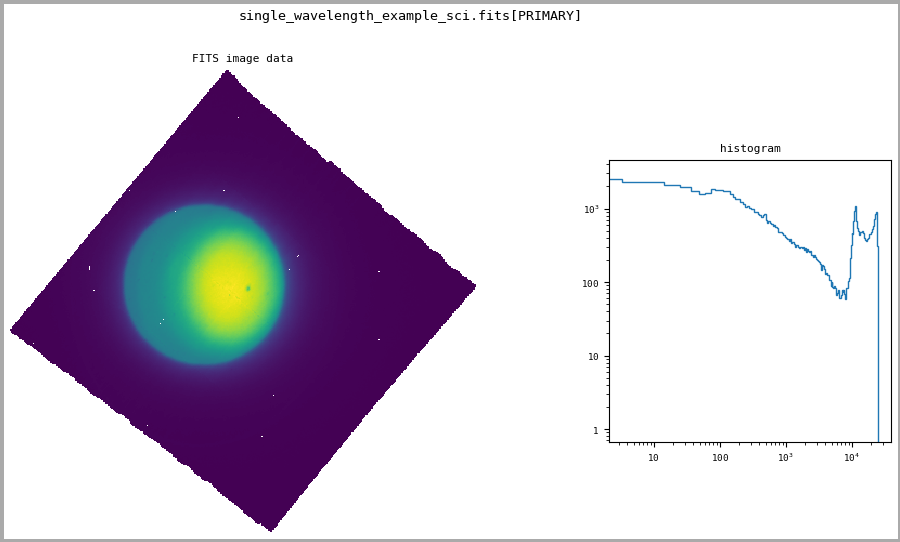

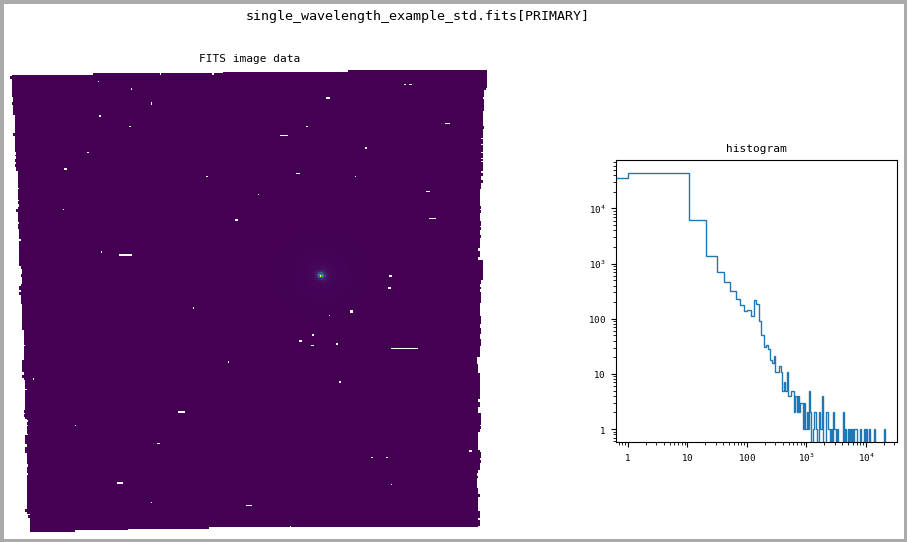

In [2]:


def display_fits(
        fpath, 
        ext='PRIMARY', 
        colour_scale=[None,None], 
        histogram_scale=(None,None), 
        histogram_basis=100,
        histogram_axis_scale=('log','log'),
    ):
    """
    Displays a 2D FITS file.

    fpath - the path to the FITS file
    ext - (optional) which extension of the FITS file to display, default is to display the primary extension.
    """
    ## Setup 
    
    # Get the data we want to display
    data = fits.getdata(fpath, ext)
    
    # A quirk of the system is that we need `.squeeze()` here as the data has three dimensions
    # not two. The "extra" dimension only has one entry, and the `.squeeze()` method removes
    # all dimensions that only have one entry
    data = data.squeeze()

    # As we expect 2-dimensional data we should test for this
    assert data.ndim == 2, f"We expect 2-dimensional data, but data has {data.ndim} dimensions."

    # Create a string that identifies the data being plotted
    data_name = fpath.name + f'[{ext}]'
    
    # Create a figure with axes
    fig, axes = plt.subplots(
        1,2,
        width_ratios=(2,1), 
        figsize=(12,6)
    )
    axes = axes.flatten() # we don't care about exact positioning right now, so don't bother with 2d grid.

    ### Perform plotting
    
    # Add title to the figure.
    fig.suptitle(data_name)
    
    ## Plot the image data
    
    # Put the data onto the plot canvas
    axes[0].imshow(data, vmin=colour_scale[0], vmax=colour_scale[1])

    # Give it a title so we know what we are looking at,
    # lets use the name of the file we are displaying.
    axes[0].set_title('FITS image data')


    axes[0].set_aspect(1)
    # We don't care about axes so remove them
    axes[0].set_axis_off()

    

    ## Plot a histogram of the data

    # Helper functions to calculate histogram bin edges
    guess_histogram_nbins = lambda n_data: int(np.e*np.cbrt(n_data))
    logspace_in_range = lambda rmin, rmax, n, base=100: (rmax-rmin)*((np.logspace(0,1,n,base=base)-1)/(base-1)) + rmin

    # Get bin edges
    if histogram_basis > 1:
        hist_bin_edges = logspace_in_range(
            histogram_scale[0] if histogram_scale[0] is not None else np.nanmin(data),
            histogram_scale[1] if histogram_scale[1] is not None else np.nanmax(data),
            guess_histogram_nbins(data.size),
            histogram_basis
        )
    else:
        hist_bin_edges = np.linspace(
            histogram_scale[0] if histogram_scale[0] is not None else np.nanmin(data),
            histogram_scale[1] if histogram_scale[1] is not None else np.nanmax(data),
            guess_histogram_nbins(data.size)
        )
    
    # plot the histogram
    axes[1].hist(
        data.flatten(), 
        bins=hist_bin_edges,
        histtype='step'
    )
    # give it a title and set to a log-log scale
    axes[1].set_title('histogram')
    axes[1].set_xscale(histogram_axis_scale[0])
    axes[1].set_yscale(histogram_axis_scale[1])    
    axes[1].set_box_aspect(1)

    # Finally, show the plot canvas
    plt.show()

# We now have our funtion written, so display the data we have
display_fits(SCI_FILE)
display_fits(STD_FILE)



Success! We have got the images to load correctly.

### Problem: Data is not in quite the correct format ###

Before we do anything else, the deconvolution algorithm has some assumptions about the layout of the data. The science observation can be pretty much anything, bu it assumes that the "Point Spread Function" (PSF), in our case the standard star, has the following properties:

1) The PSF has an odd number of pixels in the x and y direction
2) The PSF is centered. I.e., the brightest pixel is coindicent with the central pixel.
3) The sum of the PSF brightness is 1.

At the moment our standard star observation, which we will be using as our PSF, does not meet these requirements. To show this, the function below tests the data in a passed FITS file to show if it has the properties we require.

Standard star image single_wavelength_example_std.fits:
	Range of pixel values: [-4.2e+01, 2.1e+04]
	Shape of image: (306, 317)
		is odd: False
	Center pixel: [153, 158]
	Center of brightness: [164.78466564 201.41770645]
	Brightest pixel: (169, 205)
		Center of brightness at center of image: False
		Brightest pixel at center of image: False
	Sum of image: 723740.63121343
		equals one: False


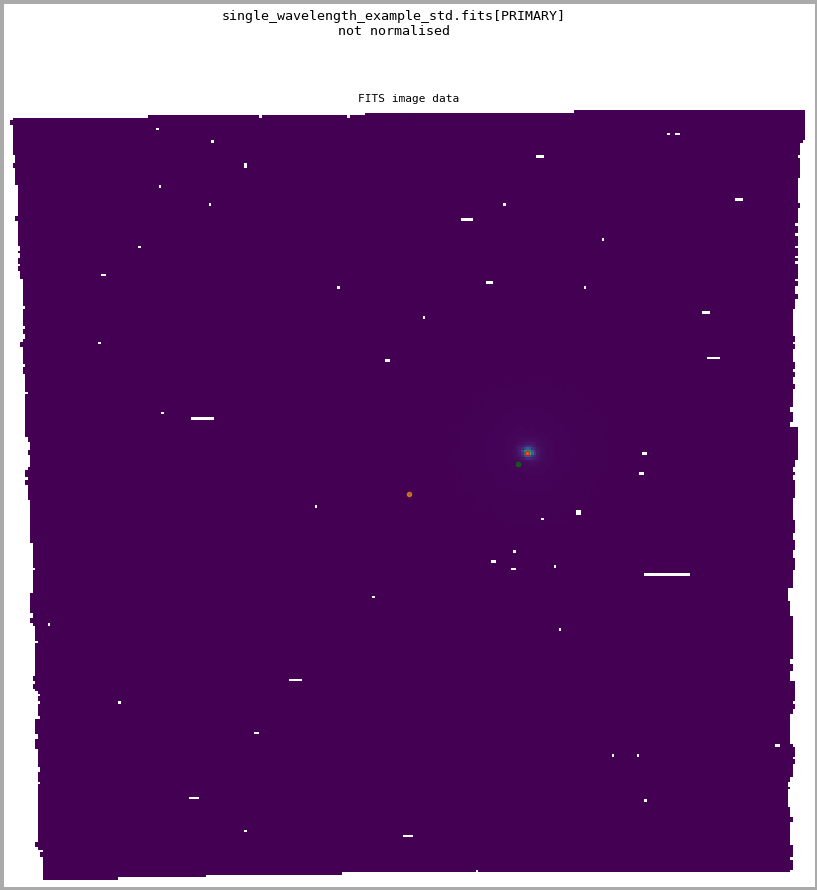

In [3]:
def show_psf_is_normalised(fpath, ext='PRIMARY', subtitle=''):
    """
    Displays data that shows if a 2D FITS file meets the crietria for a normalised PSF

    fpath - the path to the FITS file
    ext - (optional) which extension of the FITS file to display, default is to display the primary extension.
    """
    # Get the data for the standard star
    std_data = fits.getdata(fpath, ext).squeeze()
    
    # Calculate the properties we care about
    shape_of_std = std_data.shape
    center_pixel_of_std = [s//2 for s in shape_of_std]
    sum_of_std = np.nansum(std_data)
    center_of_brightness_std = np.nansum(std_data[None,...]*np.indices(std_data.shape), axis=(1,2))/np.nansum(std_data)
    brightest_pixel_std = np.unravel_index(np.nanargmax(std_data), shape_of_std)
    
    # Print out the information
    print(f'Standard star image {fpath.name}:')
    print(f'\tRange of pixel values: [{np.nanmin(std_data):.2}, {np.nanmax(std_data):.2}]')
    print(f'\tShape of image: {shape_of_std}')
    print(f'\t\tis odd: {all(s%2==1 for s in shape_of_std)}')
    print(f'\tCenter pixel: {center_pixel_of_std}')
    print(f'\tCenter of brightness: {center_of_brightness_std}')
    print(f'\tBrightest pixel: {brightest_pixel_std}')
    print(f'\t\tCenter of brightness at center of image: {all(abs(a-b) < 1E-2 for a,b in zip(center_pixel_of_std, center_of_brightness_std))}')
    print(f'\t\tBrightest pixel at center of image: {all(abs(a-b) < 1E-2 for a,b in zip(center_pixel_of_std, brightest_pixel_std))}')
    print(f'\tSum of image: {sum_of_std}')
    print(f'\t\tequals one: {sum_of_std==1}')
    
    # Plot the information
    alpha = 0.6
    plt.figure()
    plt.suptitle('\n'.join((fpath.name + f'[{ext}]',subtitle)))
    plt.imshow(std_data)
    plt.title('FITS image data')
    plt.scatter(*center_pixel_of_std[::-1], color='orange', marker='.', alpha=alpha)
    plt.scatter(*center_of_brightness_std[::-1], color='green', marker='.', alpha=alpha)
    plt.scatter(*brightest_pixel_std[::-1], color='red', marker='.', alpha=alpha)
    plt.gca().set_axis_off()
    plt.show()

show_psf_is_normalised(STD_FILE, subtitle='not normalised')

In the above image, the orange dot is the center of the image, the green dot is the center of brightness, and the red dot is the location of the brightest pixel. It is obvious that the brightest pixel is not at the center of the image.

### Solution: Normalising the PSF ###

Thankfully, there is a script included in the package that will normalise a PSF so it obeys the constraints we require. The script is the `aopp_deconv_tool.psf_normalise` module. This can be invoked via python, but we will use the operating system to call it for us in this case.

COMPLETE


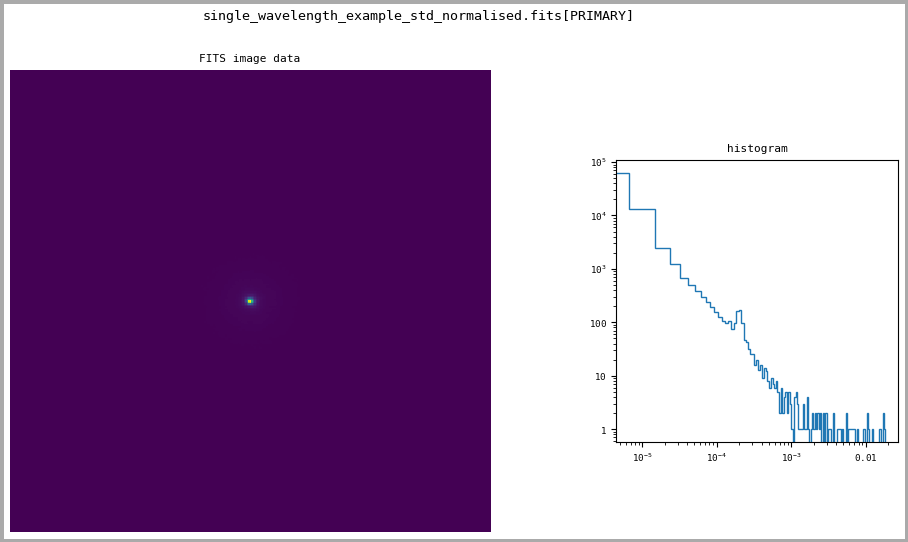

Standard star image single_wavelength_example_std_normalised.fits:
	Range of pixel values: [-2.3e-05, 0.018]
	Shape of image: (305, 317)
		is odd: True
	Center pixel: [152, 158]
	Center of brightness: [148.52369398 156.26587651]
	Brightest pixel: (152, 158)
		Center of brightness at center of image: False
		Brightest pixel at center of image: True
	Sum of image: 1.0
		equals one: True


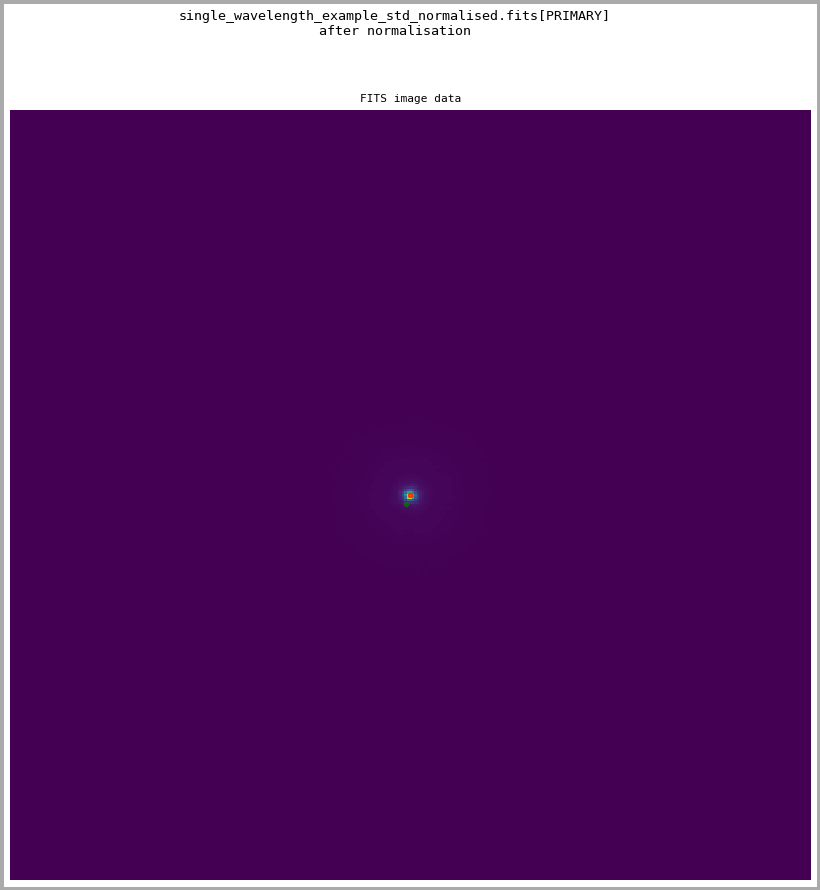

In [4]:
aopp_deconv_tool.psf_normalise.go(STD_FILE, STD_NORM_FILE)
print('COMPLETE')

# Display the resulting FITS file
display_fits(STD_NORM_FILE)

# Check that the normalised PSF has the correct properties
show_psf_is_normalised(STD_NORM_FILE, subtitle='after normalisation')

As you can see, the three properties we require are satisfied. But what about this "Center of Brightness" (COB)? The COB of an image is analagous to the "center of mass" (COM) of a sheet of metal. Ideally we want the COB to be at the center of the image as well, but that is not always possible.

## Deconvolving the image ##

Now we have our PSF normalised, we can run the observation throught the deconvolution algorithm. Again, there is a command-line script we can use, the `aopp_deconv_tool.deconvolve` module.

In [5]:
aopp_deconv_tool.deconvolve.go(SCI_FILE, STD_FILE, output_path=DECONV_FILE)
print('COMPLETE')

COMPLETE




## Comparing the result with the original ##

The resulting file has two *extensions*, a primary extension and another one that holds the *residual*. You can access a FITS file extension via its index, or via a name (if one was defined for it). In our case we know the name of the second extension is 'RESIDUAL' so we use that.

We can tell how well the deconvolution has gone by comparison between the original image, the deconvolved image, and the residual. Ideally, we are looking for the residual to be indistinguishable from background noise, and the deconvolved image to be an obviously "higher resolution" version of the original image.

As we will be reusing these plots, we will write a function for them.

In [6]:
# We will want to make these plots many times, so we will write a function to minimise typing in the future
def display_fits_comparison( 
        *args : Path|str | tuple[Path|str, str|int],     # FITS file paths, or (path, extension) to display
        compare_to : None | int | tuple[int,...] = None, # Which FITS files are we comparing against
        colour_scale : None | tuple[float,float] = None, # Colour scale to use? If None, will use the range that encompasses the FITS files we are comparing against
        ax_layout : tuple[int,int] = None,               # How to lay out the plots in Rows,Columns. If none will try and get close to square
        ax_share : tuple[str,str] = ('none','none'),     # Any shared axes between the rows and columns
        ax_show : bool | tuple[bool,...] = False,        # Show axes of plots, True/False = yes/no, tuple[True/False] = yes/no for each plot.
        subtitle : None | str = None,                    # Subtitle for the figure
        plot_only : bool = False,                        # Only show the plot if true
    ) -> None:

    

    ## Normalise arguments, get them all into a standard form

    # Ensure ax_layout is a tuple of two integers
    if ax_layout is None:
        ax_layout = (int(np.ceil(len(args)/int(np.ceil(np.sqrt(len(args)))))), int(np.ceil(np.sqrt(len(args)))))
    
    # Ensure ax_show is a tuple of booleans with the same length as the `args` list
    if type(ax_show) is not tuple:
        ax_show = tuple(ax_show for _ in args)
    
    # Ensure compare_to is a tuple of integers containing 1 to len(args) entries
    if compare_to is None:
        compare_to = tuple(range(len(args)))
    elif type(compare_to) is int:
        compare_to = (compare_to, )
        
   # Read in data
    data_map = dict(
        (Path(x[0]).name+f'[{x[1]}]', fits.getdata(*x).squeeze()) if type(x) is tuple else (Path(x).name, fits.getdata(x).squeeze()) for x in args
    )

    # Calculate colour scale
    if colour_scale is None:
        idxs = np.array(compare_to, dtype=int)
        colour_scale = (
            np.fromiter(map(np.nanmin, data_map.values()), dtype=float)[idxs].min(), 
            np.fromiter(map(np.nanmax, data_map.values()), dtype=float)[idxs].max()
        )        


    ## Create plots

    # Create figure and axes
    fig, axes = plt.subplots(
        nrows=ax_layout[0], 
        ncols=ax_layout[1], 
        sharex=ax_share[0], 
        sharey=ax_share[1],
        figsize=(ax_layout[1]*mpl.rcParams['figure.figsize'][0]/max(ax_layout), ax_layout[0]*mpl.rcParams['figure.figsize'][1]/max(ax_layout))
    )
    axes = axes.flatten() # we don't care where individual plots end up

    # Set a title for the figure
    fig.suptitle('FITS Comparison' + ('' if subtitle is None else (': '+subtitle)))

    # Remove any excess axes created
    if len(axes)  > len(data_map):
        for i in range(len(data_map), len(axes)):
            axes[i].remove()

    # Holder for calculations we will perform on the data
    data_properties = {}

    # Display data and perform any calculations
    for i, (ax, (data_name, data)) in enumerate(zip(axes, data_map.items())):
        ax.set_title(data_name)
        
        ax.imshow(data, vmin=colour_scale[0], vmax=colour_scale[1])
        
        if not ax_show[i]:
            ax.set_axis_off()

        data_properties[data_name] = {'sum' : np.nansum(data)}

    # Do any comparison of data properties
    for i, data_name in enumerate(data_properties):
        if i not in compare_to:
            continue
        for j, next_data_name in enumerate(data_properties):
            if j <= i: continue # don't perform comparisons that have already been done
            data_properties[next_data_name][f'Fraction of sum of {data_name}'] = data_properties[next_data_name]['sum']/data_properties[data_name]['sum']

    # Helper function that prints a dictionary in a human-readable way
    def print_dict(adict, level=0, fmt_dict={float:'{:G}',np.float64:'{:G}'}, indent_str='    ', major_sep='\n'):
        indent = level*indent_str
        indent_plus_one = (level+1)*indent_str
        for k,v in adict.items():
            print(f'{indent}{k}:')
            if type(v) is dict:
                print_dict(v, level+1)
            else:
                print(f'{indent_plus_one}{fmt_dict.get(type(v), '{}').format(v)}')
            if level==0:
                print(major_sep)
        return

    # Print the data properties we have calculated
    if not plot_only:
        print_dict(data_properties)

    # show the plot
    plt.show()

    # return from the function
    return

single_wavelength_example_sci.fits:
    sum:
        3.19023E+08


single_wavelength_example_sci_deconv.fits:
    sum:
        3.04879E+08
    Fraction of sum of single_wavelength_example_sci.fits:
        0.955666


single_wavelength_example_sci_deconv.fits[RESIDUAL]:
    sum:
        1.47485E+07
    Fraction of sum of single_wavelength_example_sci.fits:
        0.0462302
    Fraction of sum of single_wavelength_example_sci_deconv.fits:
        0.0483749




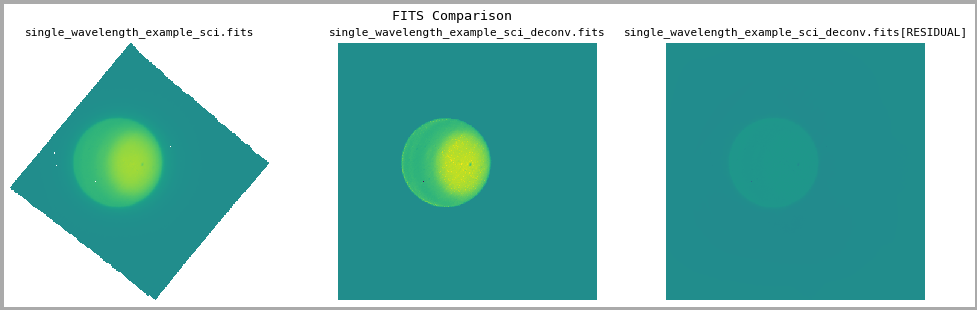

In [7]:
# Run the function we just made
display_fits_comparison(SCI_FILE, DECONV_FILE, (DECONV_FILE, 'RESIDUAL'), ax_layout=(1,3))

From the above results, a couple of things are apparent:

1) Both the deconvolved image and the residual look very similar.
2) There is still a large amount of signal left in the residual, approximately 24%.

This is indicative of not deconvolving the science image for long enough. 

### Problem: Image is not completely deconvolved ###

The FITS file that holds the deconvolved image also has some useful data about the deconvolution, including why the deconvolution stopped, in its header (this information is also in the command-line output but we are not showing that for brevity). We can access the header of the FITS file and decide upon how to proceed depending upon why the deconvolution stopped.

FITS headers can hold key-value pairs in pairs of (`PKEYn`, `PVALn`), where `n` is a number, header entries. `PKEYn` holds the name of the key, and `PVALn` contains the value of that key. I know the information we are looking for the `deconv.progress_string` key so we will search for that in the FITS file, we will also search for the `deconv.n_iter` key which will tell us the maximum number of iterations that could have been performed.

NOTE: You can also see this information via a FITS viewer e.g. QFitsView or DS9.

In [8]:
def find_header_key_value_pair(fpath, ext='PRIMARY', predicate=lambda k: True, ):

    # Get the header of the deconvolved file
    deconv_hdr = fits.getheader(fpath, ext)
        
    # Loop over the header keys and populate a new set of key-value pairs
    # from the PKEYn and PVALn header entries.
    kv_pairs = {}
    lask_key = None
    valid_continue = False
    for key in deconv_hdr:
        if key.startswith('PKEY'):
            kv_pairs[deconv_hdr[key]] = ''
            last_key = key
            valid_continue = True
        elif key.startswith('PVAL'):
            kv_pairs[deconv_hdr[last_key]] += deconv_hdr[key]
        elif valid_continue and (key == 'CONTINUE'):
            kv_pairs[deconv_hdr[last_key]] += deconv_hdr[key]
        else:
            valid_continue = False

    # Create a holder for any key-value pairs we find
    found_kvp = {}
    
    # return only the key-value pair we want
    for k,v in kv_pairs.items():
        # Remove the folder of the filenames so we don't take up loads of space
        if k.endswith('_file'):
            v = Path(v).name
        if predicate(k): # this way we can search in any way we want, we just change the predicate we pass into the function.
            found_kvp[k] = v
    
    return found_kvp

In [9]:
kvp = find_header_key_value_pair(DECONV_FILE, predicate=lambda k: k in ('deconv.progress_string', 'deconv.n_iter'))

for k,v in kvp.items():
    print(f'{k}:\n\t{v}')

deconv.n_iter:
	1000
deconv.progress_string:
	Ended at 220 iterations: Standard deviation of statistics in last 10 steps are all below minimum fraction as defined in `min_frac_stat_delta` parameter.


The "deconv.progress_string" key holds a message that tells us why the deconvolution ended, and after how many iterations. The "deconv.n_iter" key tells us the maximum number of iterations.

Therefore,
```
deconv.progress_string:
	Ended at 220 iterations: Standard deviation of statistics in last 10 steps are all below minimum fraction.
```
tells us that we stopped at 220 iterations out of a possible 1000 because one of the stopping criteria of the algorithm was tripped. I know that the stopping criteria that was tripped is `min_frac_stat_delta`. It stops the iteration if the standard deviation of the brightest pixel of the residual and the RMS of the residual is lower than its value in the last 10 iterations.

### Getting all deconv keys ###

To see the current value of `min_frac_stat_delta`, we will just display all of the key-value pairs starting with `deconv.` (keys starting with this string are added by the deconvolution script and contain information about the result). 

In [10]:
kvp = find_header_key_value_pair(DECONV_FILE, predicate=lambda k: k.startswith('deconv.'))

for k,v in kvp.items():
    print(f'{k}:\n\t{v}')

deconv.obs_file:
	single_wavelength_example_sci.fits
deconv.psf_file:
	single_wavelength_example_std.fits
deconv.parameters_recorded_at_timestamp:
	2024-08-29T16:48:20.444824+0000
deconv.n_iter:
	1000
deconv.progress_string:
	Ended at 220 iterations: Standard deviation of statistics in last 10 steps are all below minimum fraction as defined in `min_frac_stat_delta` parameter.
deconv.loop_gain:
	0.02
deconv.threshold:
	0.3
deconv.n_positive_iter:
	0
deconv.noise_std:
	0.1
deconv.rms_frac_threshold:
	0.01
deconv.fabs_frac_threshold:
	0.01
deconv.max_stat_increase:
	inf
deconv.min_frac_stat_delta:
	0.001
deconv.give_best_result:
	False
deconv.clean_beam_sigma:
	0


The `deconv.min_frac_stat_delta` parameter is what stopped the algorithm, and is set to a conservative value, 1E-3, by default. If we decrease this value, our deconvolution will run for longer and move more signal from the residual to the deconvolved image.

### Solution: Re-run command with a smaller `min_frac_stat_delta` parameter ###

Let's re-run the command with `min_frac_stat_delta` set to a much smaller value, 1E-5 should be small enough.

In [11]:
aopp_deconv_tool.deconvolve.go(SCI_FILE, STD_FILE, output_path=DECONV_FILE, min_frac_stat_delta=1E-5)
print('COMPLETE')

COMPLETE


## Comparing the new result with the original ##

Just as before, we can compare the new result, we are looking for the same things. Ideally, the residual to be indistinguishable from background noise, and the deconvolved image to be an obviously "higher resolution" version of the original image. We will also print out the deconvolution key-pair values.

deconv.obs_file:
	single_wavelength_example_sci.fits
deconv.psf_file:
	single_wavelength_example_std.fits
deconv.parameters_recorded_at_timestamp:
	2024-08-29T16:49:04.473661+0000
deconv.n_iter:
	1000
deconv.progress_string:
	Ended at 1000 iterations: Maximum number of iterations reached.
deconv.loop_gain:
	0.02
deconv.threshold:
	0.3
deconv.n_positive_iter:
	0
deconv.noise_std:
	0.1
deconv.rms_frac_threshold:
	0.01
deconv.fabs_frac_threshold:
	0.01
deconv.max_stat_increase:
	inf
deconv.min_frac_stat_delta:
	1e-05
deconv.give_best_result:
	False
deconv.clean_beam_sigma:
	0
single_wavelength_example_sci.fits:
    sum:
        3.19023E+08


single_wavelength_example_sci_deconv.fits:
    sum:
        3.13131E+08
    Fraction of sum of single_wavelength_example_sci.fits:
        0.981532


single_wavelength_example_sci_deconv.fits[RESIDUAL]:
    sum:
        6.52541E+06
    Fraction of sum of single_wavelength_example_sci.fits:
        0.0204544
    Fraction of sum of single_wavelength_exa

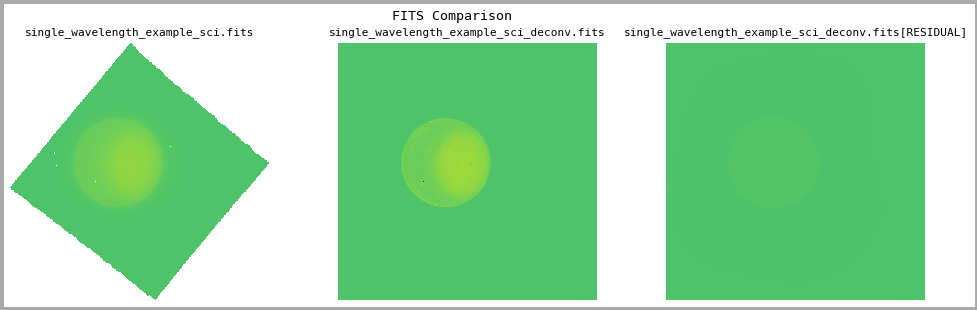

In [12]:
# Display FITS header information
kvp = find_header_key_value_pair(DECONV_FILE, predicate=lambda k: k.startswith('deconv.'))

for k,v in kvp.items():
    print(f'{k}:\n\t{v}')

# Compare results with original file
display_fits_comparison(SCI_FILE, DECONV_FILE, (DECONV_FILE, 'RESIDUAL'), ax_layout=(1,3))

A few things are going on here. Firstly, `deconv.progress_string` shows we completed the full 1000 iterations. Good, that is what we wanted. Also, we have reduced the amout of signal in the residual to only 2%, that is also good. However, the resulting image does not look good. There are two reasons for this: 
1) by default the colour range of the images is such that it encompasses the range of all the images;
2) There are *artefacts* in this image that cause problems with the deconvolution (see the bottom left quarter of the planet in the middle image).

To fix (1), we tell the plotting function to only use the range of one of the image (e.g. the original).

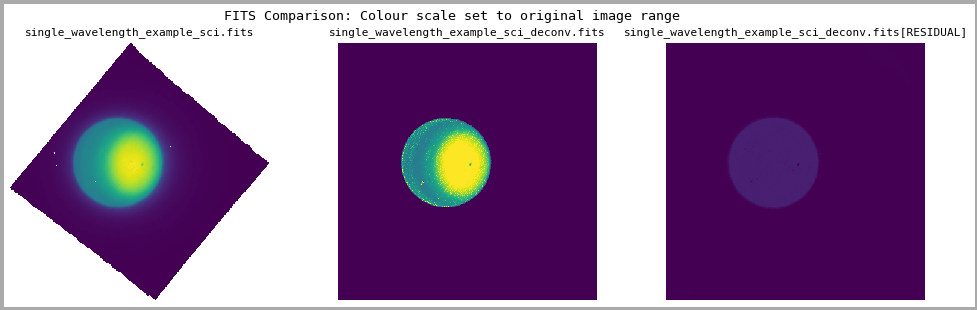

In [13]:
# Only use the 0th image for comparison, and only show the plot
display_fits_comparison(SCI_FILE, 
                        DECONV_FILE, 
                        (DECONV_FILE, 'RESIDUAL'), 
                        compare_to=(0,), 
                        ax_layout=(1,3), 
                        plot_only=True, 
                        subtitle='Colour scale set to original image range'
)

Fixing (2) is more difficult. You can still see the problem in the figure we just made, the bottom left quarter of the middle image has a bright spot that coincides with missing data (white region) in the original left image.

There is also another problem. Compared to the first deconvolution result, this result is very *speckly*. There are discrete pixels that are noticably brighter than their neighbours. There is no physical reason for this, it is unfortunately one of the problems with the CLEAN algorithm.

Thankfully, there are ways to deal with these two problems.

## Artefact Reduction ##

An artefact is any feature on an image that is due to flaws in the instrumentation and/or processing. We are going to restrict ourselves to worrying about the subset artefacts that cause a deconvolution to fail. In the case of CLEAN algorithms, these are artefacts that are smaller that the PSF used for the deconvolution. Instead of solving the hard problem of identifying artefacts in general, we are going to work on the much easier problem of identifying artefacts that are a problem for the deconvolution algorithm, and reducing their influence such that the deconvolution will complete.

There are a few scripts provided in *aopp_deconv_tool* to help with this.

aopp_deconv_tool.artefact_detection
: Creates a map of the image that rates each pixel by how likely it is to be a problematic artefact

aopp_deconv_tool.create_bad_pixel_mask
: Takes the result of `aopp_deconv_tool.artefact_detection` as a FITS file and applies a threshold. Can also accept DS9 region files to manually designate artefacts to be masked. Creates a true/false mask where true values indicate a pixel is part of (of influenced by) an artefact.

aopp_deconv_tool.interpolate
: Accepts an observation FITS file and a boolean mask FITS file (the output of `aopp_deconv_tool.create_bad_pixel_mask`), and interpolates over the observations where the mask is true. Creates a FITS file of the result that is the same as the input observation FITS file except fot the interpolation.

We will apply these three steps, and show the results of each of them.


In [14]:
aopp_deconv_tool.artefact_detection.go(SCI_FILE, output_path=SCI_ARTEFACT_FILE)
print('COMPLETE')

COMPLETE


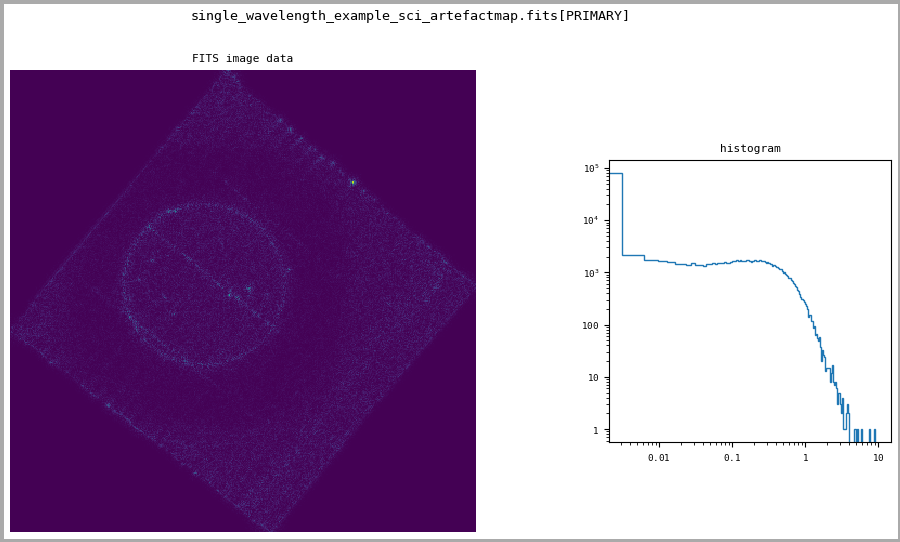

In [15]:
# Display the result
display_fits(SCI_ARTEFACT_FILE, colour_scale=(0, 10), histogram_scale=(0,10))

The bright regions in the image are pixels that the script things are influenced by artefacts. We can now pass this map to the next step.

In [16]:
aopp_deconv_tool.create_bad_pixel_mask.go(SCI_ARTEFACT_FILE, output_path=SCI_ARTEFACT_MASK_FILE)
print('COMPLETE')

COMPLETE


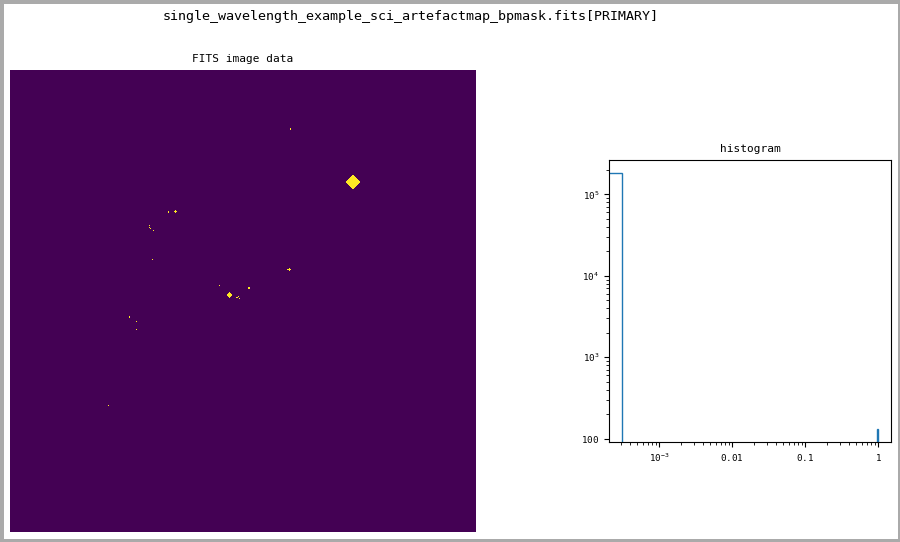

In [17]:
# Display the result
display_fits(SCI_ARTEFACT_MASK_FILE)

The pixels are selected by `aopp_deconv_tool.create_bad_pixel_mask` by a threshold value which is 3 by default. The resulting binary image then undergoes dilation based on the value of the pixel, i.e. a pixel with a value of 5 would be dilated twice so it would mask its 2-step away neighbours. This process ensures that artefact edge effects are caught.

We pass this mask and the original observation to the next step.

In [18]:
aopp_deconv_tool.interpolate.go(SCI_FILE, SCI_ARTEFACT_MASK_FILE, output_path=SCI_INTERP_FILE)
print('COMPLETE')

COMPLETE


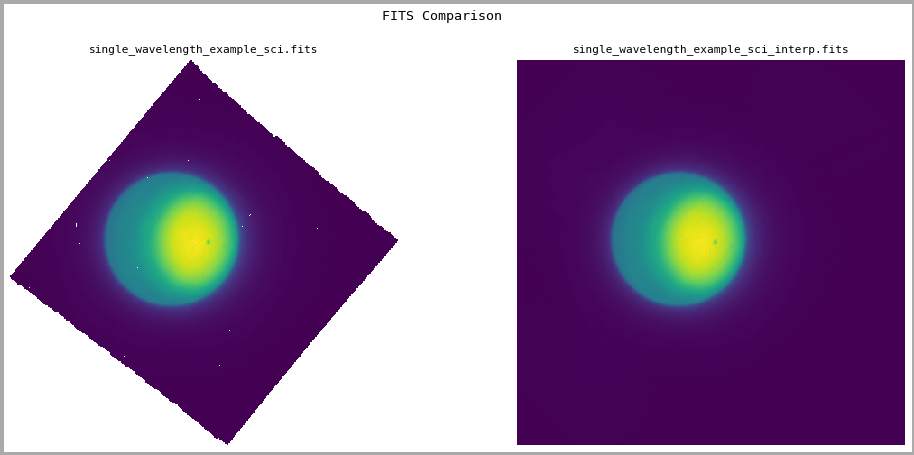

In [19]:
# Display the result
display_fits_comparison(SCI_FILE, SCI_INTERP_FILE, plot_only=True)

The above plot show the missing data in the original image has successfully been filled in. Interestingly, the dark dot area on the right of the disk has not been touched very much. This is because the threshold we have used for `aopp_deconv_tool.create_bad_pixel_mask` was the default of 3, we could lower it but for our purposes that dark dot doesn't stop the deconvolution process. We can now use the interpolated FITS file in place of the original FITS file.

### Faster deconvolution by tweaking parameters ###

Instead of re-running the original command, which can take a lot of time. We can increase the `loop_gain` parameter. This parameter controls the fraction of brightness of a pixel transferred from the residual to the components upon each iteration. The current value is very conservative, so it can be safely increased in most cases. The relationship between `loop_gain` and the maximum number of iterations`n_iter` is not linear, so increasing to 0.2 means we only need about 200 interations.


In [20]:
aopp_deconv_tool.deconvolve.go(
    SCI_INTERP_FILE, 
    STD_FILE, 
    output_path=DECONV_FILE, 
    min_frac_stat_delta=1E-5, 
    loop_gain=0.2, 
    n_iter=200
)
print('COMPLETE')

COMPLETE


deconv.obs_file:
	single_wavelength_example_sci_interp.fits
deconv.psf_file:
	single_wavelength_example_std.fits
deconv.parameters_recorded_at_timestamp:
	2024-08-29T16:49:23.085200+0000
deconv.n_iter:
	200
deconv.progress_string:
	Ended at 200 iterations: Maximum number of iterations reached.
deconv.loop_gain:
	0.2
deconv.threshold:
	0.3
deconv.n_positive_iter:
	0
deconv.noise_std:
	0.1
deconv.rms_frac_threshold:
	0.01
deconv.fabs_frac_threshold:
	0.01
deconv.max_stat_increase:
	inf
deconv.min_frac_stat_delta:
	1e-05
deconv.give_best_result:
	False
deconv.clean_beam_sigma:
	0
single_wavelength_example_sci_interp.fits:
    sum:
        3.2258E+08


single_wavelength_example_sci_deconv.fits:
    sum:
        3.37728E+08
    Fraction of sum of single_wavelength_example_sci_interp.fits:
        1.04696


single_wavelength_example_sci_deconv.fits[RESIDUAL]:
    sum:
        -1.48459E+07
    Fraction of sum of single_wavelength_example_sci_interp.fits:
        -0.0460222




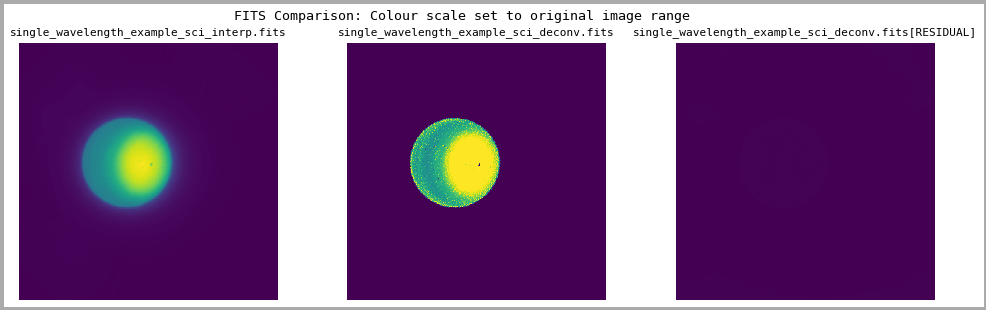

In [21]:
# Show information in header
kvp = find_header_key_value_pair(DECONV_FILE, predicate=lambda k: k.startswith('deconv.'))

for k,v in kvp.items():
    print(f'{k}:\n\t{v}')

# As before, only use the 0th image for comparison
display_fits_comparison(SCI_INTERP_FILE, 
                        DECONV_FILE, 
                        (DECONV_FILE, 'RESIDUAL'), 
                        compare_to=(0,), 
                        ax_layout=(1,3), 
                        subtitle='Colour scale set to original image range'
)

The above images show that removing/reducing the artefacts does indeed fix the problem we were having. There is now no bright patch in the bottom left corner of the deconvolved image. However we still have the speckles to deal with.

## Removing Speckles ##

Speckles are a problem with the threshold value of Modified CLEAN. At the start of an iteration, Modified CLEAN chooses pixels to operate on for that iteration. When the spread of pixel values chosen is of a similar magnitude to the noise of the image, the noise tends to reinforce itself and shows up as regular specking. There is a "smart" threshold setting that aims to reduce the specking problem by heuristically choosing a threshold. This mode is enabled when the `--threshold` parameter is a negative number, usually -1. By default `--threshold` is set to 0.3 which means that pixels will be chosen that are brighter than 0.3 times the brightest pixel in the residual. Automatic threshold selection is slower than a constant value, but it tries to account for the source of speckling and reduce it if possible.

Another thing to note in the above result is that the fraction of signal in the residual has become negative. This is a fairly common occurance, in this case a negative 5% is a bit large, but that's due to the speckling. Ideally the fraction of signal in the residual should be around zero, within the noise level of the data, which is about 1-2% in this case.

In [25]:
aopp_deconv_tool.deconvolve.go(
    SCI_INTERP_FILE, 
    STD_FILE, 
    output_path=DECONV_FILE, 
    min_frac_stat_delta=1E-5, 
    loop_gain=0.2, 
    n_iter=200,
    threshold=-1,
)
print('COMPLETE')

COMPLETE


deconv.obs_file:
	single_wavelength_example_sci_interp.fits
deconv.psf_file:
	single_wavelength_example_std.fits
deconv.parameters_recorded_at_timestamp:
	2024-08-29T16:50:35.671317+0000
deconv.n_iter:
	200
deconv.progress_string:
	Ended at 49 iterations: Root mean squared statistic of residual has dropped below set threshold defined in `rms_frac_threshold` parameter.
deconv.loop_gain:
	0.2
deconv.threshold:
	-1.0
deconv.n_positive_iter:
	0
deconv.noise_std:
	0.1
deconv.rms_frac_threshold:
	0.01
deconv.fabs_frac_threshold:
	0.01
deconv.max_stat_increase:
	inf
deconv.min_frac_stat_delta:
	1e-05
deconv.give_best_result:
	False
deconv.clean_beam_sigma:
	0
single_wavelength_example_sci_interp.fits:
    sum:
        3.2258E+08


single_wavelength_example_sci_deconv.fits:
    sum:
        3.2635E+08
    Fraction of sum of single_wavelength_example_sci_interp.fits:
        1.01169


single_wavelength_example_sci_deconv.fits[RESIDUAL]:
    sum:
        -4.07309E+06
    Fraction of sum of singl

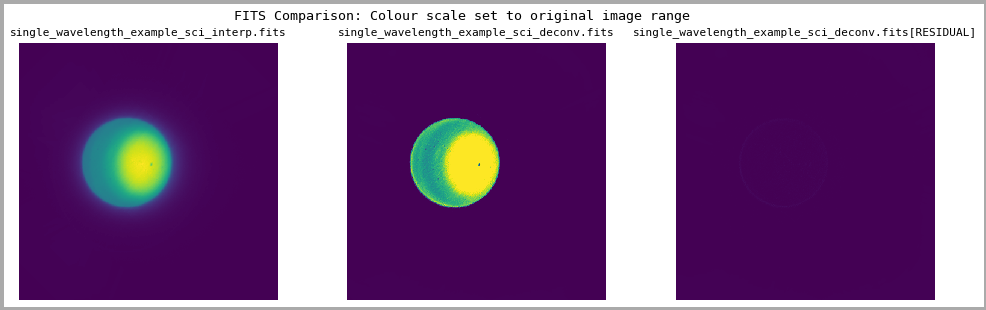

In [26]:
# Show information in header
kvp = find_header_key_value_pair(DECONV_FILE, predicate=lambda k: k.startswith('deconv.'))

for k,v in kvp.items():
    print(f'{k}:\n\t{v}')

# As before, only use the 0th image for comparison
display_fits_comparison(SCI_INTERP_FILE, 
                        DECONV_FILE, 
                        (DECONV_FILE, 'RESIDUAL'), 
                        compare_to=(0,), 
                        ax_layout=(1,3), 
                        subtitle='Colour scale set to original image range'
)

The above result looks a lot better than before. There is a slight oversaturation in the middle image (the deconvolution result) but that is to be expected. The result of the deconvolution has not had its light spread around, so its brighter areas should be brighter and its darker areas darker. The residual is so small it is almost impossible to see, and the signal fraction in the residual is still negative but around the 0.2% level, within the error we expect.

If we look at each of the images individually we can get a bit more information.

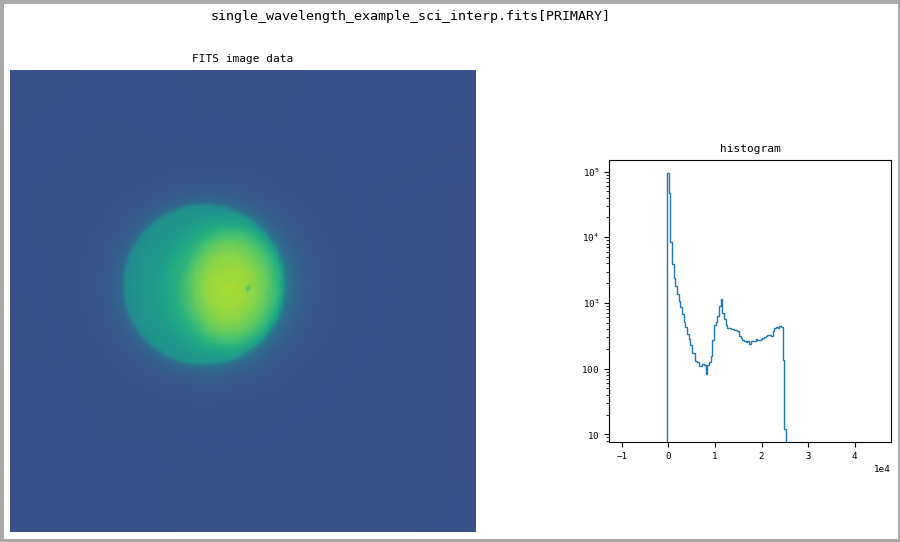

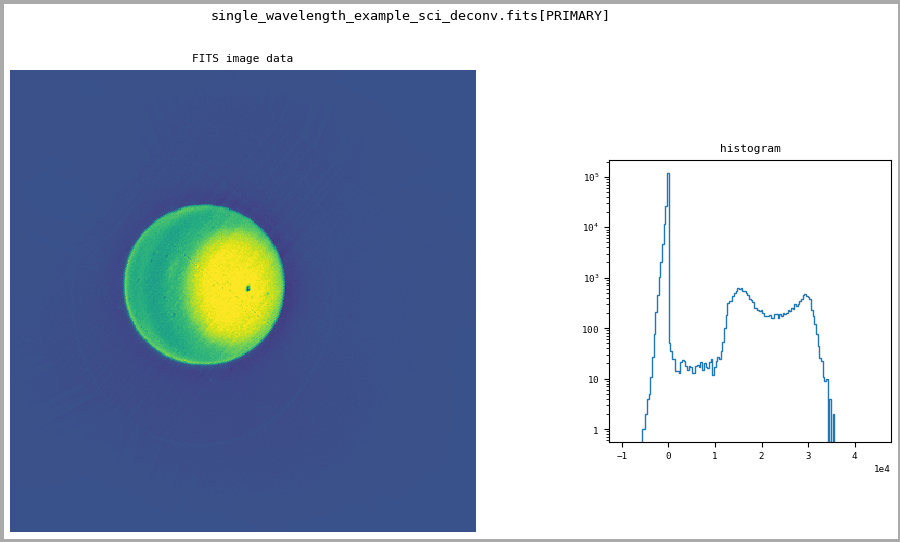

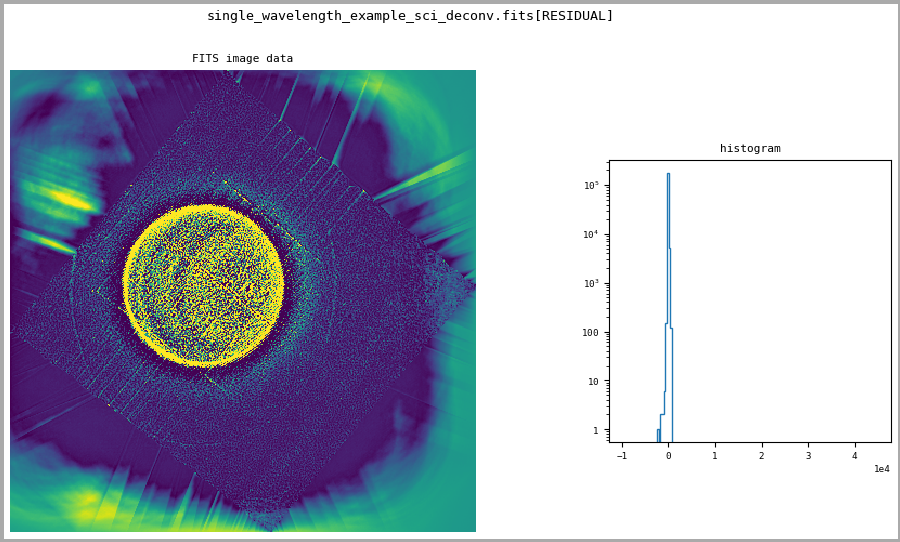

In [27]:
display_fits(
    SCI_INTERP_FILE, 
    colour_scale=(-1E4,3E4), 
    histogram_scale=(-1E4,4.5E4), 
    histogram_basis=1, 
    histogram_axis_scale=('linear','log')
)
display_fits(
    DECONV_FILE, 
    colour_scale=(-1E4,3E4), 
    histogram_scale=(-1E4,4.5E4), 
    histogram_basis=1, 
    histogram_axis_scale=('linear','log')
)
display_fits(
    DECONV_FILE, 'RESIDUAL', 
    colour_scale=(-50,50), 
    histogram_scale=(-1E4,4.5E4), 
    histogram_basis=1, 
    histogram_axis_scale=('linear','log')
)

We have been quite aggressive in deconvolving the data in this case, and I've set the colour scales so we can see more detail and compare between images more easily. There are some interesting features in the above plots. 

Comparing the original image (top) with the deconvolved image (middle) we can see the deconvolved image is much better defined, smudges in the original have become distinct features, it is even possible to see the planet's ring in the lower half of the image (about 1 planet radius away from the disk). 

You can also see many more artefacts in the deconvolved image:
* There are some straight lines running from top-left to bottom-right
* Lines with what looks like shadowing going from bottom-left to top-right
* The large dot we identified earlier
* Many smaller dots, mostly on the left hand side of the disk.

These are features of the detector, the instrument used to obtain this image was an [*integral field unit*](https://www.eso.org/public/teles-instr/technology/ifu/). There is a lot of manipulation of the light as it travels through the optical system, and some of these artefacts are the result, others are the result of defects in the CCD.

Looking at the residual, there is a very apparent rectangle set into some "cloudyness". This is due to how the deconvolution algorithm handles edge-effects. The "cloudy" region normally contains no data (NANs), but was filled with a value to avoid edge effects during deconvolution and is therefore not real signal. The bottom left to top-right ridges are still visible, and the planet disk is still visible as well, along with some of the planet's ring. However, comparing histograms between the images, it is obvious that the vast majority of emission is explained by the deconvolved image.

Further deconvolution would not help in this case as problems with speckling can continue to arise even when using the "smart" threshold setting (there is a limit to how smart it is). If we need to, we can do some [regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to push our result to be something more physically plausible. However, you can start to lose some of the nice properties that Modified CLEAN has (e.g. flux conservation).

There is another source of noise we have not discussed in this example. The PSF itself is noisy, and will suffer from the same artefacts that the science observation suffers from. *aopp_deconv_tool* does include a way to model a PSF, please see the relevant example.

# Conclusion #

We started with a science observation and a standard star observation. Normalising the standard star so it could be used as a PSF we deconvolved the science observation with default settings. Then we introduced different problems and solutions to those problems as they arised.

1) The initial deconvolution stopped before the vast majority of the original observation was explained by the deconvolved image, this was fixed by altering some parameters so the deconvolution continued.
2) Artefacts stopped the image deconvolving beyond a certain point, as they were smaller than the PSF the deconvolution process gets 'stuck' as it cannot account for such small features. We used the artefact reduction tools in *aopp_deconv_tool* to reduce the effect of the artefacts and let the deconvolution process continue.
3) We encountered speckling due to deconvolution proceeding close to the noise level of the observations. This can be corrected for in multiple ways (including reducing the `--threshold` parameter as the as deconvolution process continues), we chose to use the "smart threshold" (`--threshold` set to -1). This does effectively reduce the speckling, but cannot eliminate it entirely. However it is often good enough to get to the noise level of an image.

Finally we examined the last deconvolved image, compared it to the original, pointed out features of the deconvolved image and the residual, and finally touched upon the topics of regularisation and PSF modelling.

